In [ ]:
import os
os._exit(00)

In [1]:
import copy
import math
import pickle
import os
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
sys.path.insert(0, "/Users/erotokritosskordilis/git-repos/Autonomous_Fed/")
sys.path.insert(0, "/Users/erotokritosskordilis/git-repos/Autonomous_Fed/scripts")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from config import Config
from data_prep import DataPrep, gen_seq, series_to_supervised, plotting

from forecasting_models import (   
    trainTransformer,
    train_LSTM, 
    linearModels, 
    gaussianProcess, 
    decisionTree, 
    ensembleModels
)

In [2]:
# Load configuration file with necessary parameters
config = Config()
data_prep = DataPrep()

In [3]:
specifications_set = input("Choose specifications set: {0, 1, 2, 3, A, B, C}: ")
if specifications_set.isdigit():
    specifications_set = int(specifications_set)
df,scaler = data_prep.read_data(specifications_set=specifications_set)
print(df.head())

Choose specifications set: {0, 1, 2, 3, A, B, C}:  A


   FEDFUNDS  Inflation_1  Output_GAP
0  0.056578     0.052549    0.495977
1  0.064672     0.063584    0.588232
2  0.078771     0.067262    0.744977
3  0.108706     0.082501    0.814635
4  0.161686     0.110878    0.866216


Transformer does not exist
LSTM does not exist
2/2 [==============================] - 0s 1ms/step


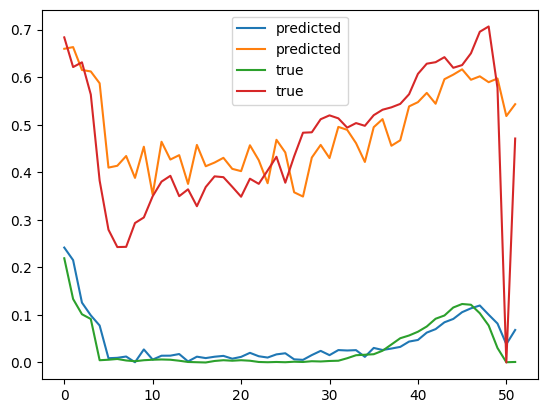

VAE results
RMSE: 0.077; R2 score: 0.587
LR does not exist


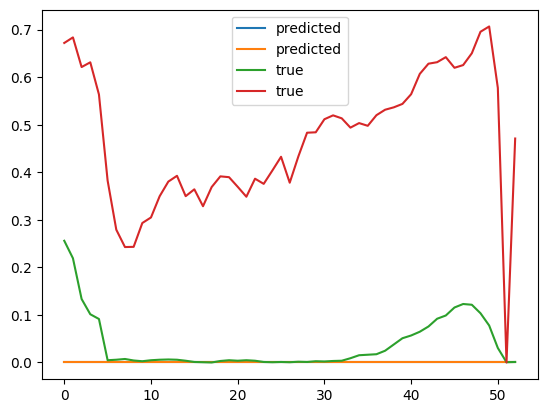

LR results
RMSE: 0.350; R-squared: -5.780
RF does not exist


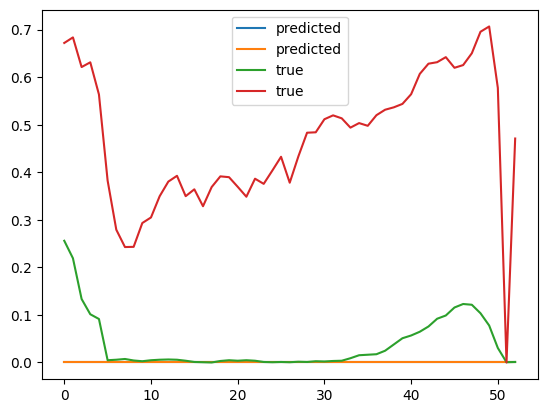

RF results
RMSE: 0.350; R-squared: -5.780


In [4]:
model_path = '/Users/erotokritosskordilis/git-repos/Autonomous_Fed/saved_models/'

def predModel(algorithm, model_path, inputs):
    # Load the model
    try:
        with open(model_path+f'{algorithm}_FedModel_{specifications_set}.pkl', 'rb') as file:
            loaded_model = pickle.load(file)
        preds = loaded_model.predict(inputs)  
        return preds
    except:
        print(f"{algorithm} does not exist")
        return np.zeros((inputs.shape[0],inputs.shape[1]-1))    
        

rmses = []
r2s = []

if specifications_set == 0:
    df_preds = pd.DataFrame({"Linear_Regression":{'Inflation_1':[],
                                                  'Inflation_residuals':[],
                                                  'Output_GDP':[]},
                             "Random_Forest":{'Inflation_1':[],
                                                  'Inflation_residuals':[],
                                                  'Output_GDP':[]},
                             "LSTM":{'Inflation_1':[],
                                                  'Inflation_residuals':[],
                                                  'Output_GDP':[]},
                             "Transformer":{'Inflation_1':[],
                                                  'Inflation_residuals':[],
                                                  'Output_GDP':[]},
                             "VAE":{'Inflation_1':[],
                                                  'Inflation_residuals':[],
                                                  'Output_GDP':[]}})
elif specifications_set == 1:
    df_preds = pd.DataFrame({"Linear_Regression":{'CPI_Inflation':[],
                                              'Output_GDP':[]},
                         "Random_Forest":{'CPI_Inflation':[],
                                              'Output_GDP':[]},
                         "LSTM":{'CPI_Inflation':[],
                                              'Output_GDP':[]},
                         "Transformer":{'CPI_Inflation':[],
                                              'Output_GDP':[]},
                         "VAE":{'CPI_Inflation':[],
                                              'Output_GDP':[]}})
elif specifications_set == 2:
    df_preds = pd.DataFrame({"Linear_Regression":{'log_GDP':[],
                                                  'log_potential_GDP':[],
                                                  'log_CPI':[]},
                             "Random_Forest":{'log_GDP':[],
                                                  'log_potential_GDP':[],
                                                  'log_CPI':[]},
                             "LSTM":{'log_GDP':[],
                                                  'log_potential_GDP':[],
                                                  'log_CPI':[]},
                             "Transformer":{'log_GDP':[],
                                                  'log_potential_GDP':[],
                                                  'log_CPI':[]},
                             "VAE":{'log_GDP':[],
                                                  'log_potential_GDP':[],
                                                  'log_CPI':[]}})
elif specifications_set == 3:
    df_preds = pd.DataFrame({"VAE":{'log_GDP':[],
                                    'log_potential_GDP':[],
                                    'log_CPI':[]}})
elif specifications_set == 'A':
    df_preds = pd.DataFrame({"VAE":{'Inflation_1':[],
                                    'Output_GDP':[],
                                    'Natural_Rate_of_Interest':[]}})
elif specifications_set == 'C':
    df_preds = pd.DataFrame({"VAE":{'log_GDP':[],
                                    'log_potential_GDP':[],
                                    'log_CPI':[],
                                    'Natural_Rate_of_Interest':[]}})
plot_results = True

models = ['transformer', 'lstm', 'vae', 'lr', 'rf']

LSTM = False

for model_type in models:
    if model_type == "lstm":
        # Load encoder and decoder
        try:
            lstm_model = tf.keras.models.load_model(
                model_path+f"LSTM_FedModel_{specifications_set}.keras", 
                compile=False,
                safe_mode=False)
        except:
            print("LSTM does not exist")
            rmses.append(float('NaN'))
            r2s.append(float('NaN'))
        else:
            reframed = series_to_supervised(df, config.sequence_length, 1)
        
            # Keep the t-1 columns for all four features, drop the t columns for 
            # the features to be predicted (all except FEDFUNDS)
            reframed.drop(reframed.columns[df.shape[1]+1:], axis=1, inplace=True)
            
            # Split into train and test sets (80-20)
            train_split = config.train_split
            values = reframed.values
            test = values[int(len(values)*train_split):, :]
            
            # Split into input and outputs, and reshape
            test_input, test_output = test[:, :-1], test[:, 1:-1]
            test_input = test_input.reshape((test_input.shape[0], config.sequence_length, test_input.shape[1]))
            
            preds = lstm_model.predict(test_input)
            if specifications_set == 0:
                df_preds['LSTM']['Inflation_1'] = preds[:,0]
                df_preds['LSTM']['Inflation_residuals'] = preds[:,1]
                df_preds['LSTM']['Output_GDP'] = preds[:,2]
            elif specifications_set == 1:
                df_preds['LSTM']['CPI_Inflation'] = preds[:,0]
                df_preds['LSTM']['Output_GDP'] = preds[:,1]
            else:
                df_preds['LSTM']['log_GDP'] = preds[:,0]
                df_preds['LSTM']['log_potential_GDP'] = preds[:,1]
                df_preds['LSTM']['log_CPI'] = preds[:,2]
            
            # plot results
            if plot_results:
                plt.plot(preds, label="predicted")
                plt.plot(test_output, label="true")
                plt.legend()
                plt.show()
        
            # calculate RMSE, R2 score
            rmse = math.sqrt(mean_squared_error(test_output, preds))
            r2 = r2_score(test_output, preds)
            print("LSTM results")
            print(f'RMSE: {rmse:.3f}; R2 score: {r2:.3f}')
            rmses.append(rmse)
            r2s.append(r2)
    elif model_type == "transformer":
        # Load encoder and decoder
        try:
            transformer = tf.keras.models.load_model(
                model_path+f"Transformer_FedModel_{specifications_set}.keras", 
                compile=False,
                safe_mode=False)
        except:
            print("Transformer does not exist")
            rmses.append(float('NaN'))
            r2s.append(float('NaN'))
        else: 
            reframed = series_to_supervised(df, config.sequence_length, 1)
        
            # Keep the t-1 columns for all four features, drop the t columns for 
            # the features to be predicted (all except FEDFUNDS)
            reframed.drop(reframed.columns[df.shape[1]+1:], axis=1, inplace=True)
            
            # Split into train and test sets (80-20)
            train_split = config.train_split
            values = reframed.values
            test = values[int(len(values)*train_split):, :]
            
            # Split into input and outputs, and reshape
            test_input, test_output = test[:, :-1], test[:, 1:-1]
            test_input = test_input.reshape((test_input.shape[0], config.sequence_length, test_input.shape[1]))
            
            preds = transformer.predict(test_input)
            if specifications_set == 0:
                df_preds['Transformer']['Inflation_1'] = preds[:,0]
                df_preds['Transformer']['Inflation_residuals'] = preds[:,1]
                df_preds['Transformer']['Output_GDP'] = preds[:,2]
            elif specifications_set == 1:
                df_preds['Transformer']['CPI_Inflation'] = preds[:,0]
                df_preds['Transformer']['Output_GDP'] = preds[:,1]
            else:
                df_preds['Transformer']['log_GDP'] = preds[:,0]
                df_preds['Transformer']['log_potential_GDP'] = preds[:,1]
                df_preds['Transformer']['log_CPI'] = preds[:,2]

            # plot results
            if plot_results:
                plt.plot(preds, label="predicted")
                plt.plot(test_output, label="true")
                plt.legend()
                plt.show()
        
            # calculate RMSE, R2 score
            rmse = math.sqrt(mean_squared_error(test_output, preds))
            r2 = r2_score(test_output, preds)
            print(f"{model_type.upper()} results")
            print(f'RMSE: {rmse:.3f}; R2 score: {r2:.3f}')
            rmses.append(rmse)
            r2s.append(r2)
    elif model_type == 'vae':
        """
        The VAE here is a transitional VAE; that means that, for inputs Y_{1,..,T} we have:
        - Encoder: fits probability distribution P(X_t|Y_{t-1})
        - Decoder: fits probability distribution P(Y_t|X_t)
        """
        try:
            decoder = tf.keras.models.load_model(
                    model_path+f"decoder_FedModel_{specifications_set}.keras", 
                    compile=False,
                    safe_mode=False)
            encoder = tf.keras.models.load_model(
                    model_path+f"encoder_FedModel_{specifications_set}.keras", 
                    compile=False,
                    safe_mode=False)
        except:
            print("VAE encoder/decoder do not exist")
            rmses.append(float('NaN'))
            r2s.append(float('NaN'))
        else:
            if LSTM:
                sequence_input = []
                sequence_target = []
                
                for seq in gen_seq(df, config.sequence_length, [col for col in df.columns]):
                    sequence_input.append(seq)
                    sequence_target.append(seq)
                
                    
                sequence_input = np.asarray(sequence_input)
                sequence_target = np.asarray(sequence_target)
                
                # Train-test split
                sequence_input_test = sequence_input[int(len(sequence_input)*config.train_split):]
                sequence_target_test = sequence_target[int(len(sequence_target)*config.train_split):][:,:,1:]
    
                z_mean, z_logvar, z = encoder.predict(sequence_input_test)
                preds = decoder.predict(z).reshape(sequence_target_test.shape[0], sequence_target_test.shape[2])
                test_output = sequence_target_test.reshape(sequence_target_test.shape[0], sequence_target_test.shape[2])

                if specifications_set == 0:
                    df_preds['VAE']['Inflation_1'] = preds[:,0]
                    df_preds['VAE']['Inflation_residuals'] = preds[:,1]
                    df_preds['VAE']['Output_GDP'] = preds[:,2]
                elif specifications_set == 1:
                    df_preds['VAE']['CPI_Inflation'] = preds[:,0]
                    df_preds['VAE']['Output_GDP'] = preds[:,1]
                elif specifications_set == 2:
                    df_preds['VAE']['log_GDP'] = preds[:,0]
                    df_preds['VAE']['log_potential_GDP'] = preds[:,1]
                    df_preds['VAE']['log_CPI'] = preds[:,2]
                elif specifications_set == 'A':
                    df_preds['VAE']['Inflation_1'] = preds[:,0]
                    df_preds['VAE']['Output_GDP'] = preds[:,1]
                    #df_preds['VAE']['Natural_Rate_of_Interest'] = preds[:,2]
                elif specifications_set == 'C':
                    df_preds['VAE']['log_GDP'] = preds[:,0]
                    df_preds['VAE']['log_potential_GDP'] = preds[:,1]
                    df_preds['VAE']['log_CPI'] = preds[:,2]
                    #df_preds['VAE']['Natural_Rate_of_Interest'] = preds[:,3]
    
                # plot results
                if plot_results:
                    plt.plot(preds, label="predicted")
                    plt.plot(test_output, label="true")
                    plt.legend()
                    plt.show()
                
                # calculate RMSE, R2 score
                rmse = math.sqrt(mean_squared_error(test_output, preds))
                r2 = r2_score(test_output, preds)
                print(f"{model_type.upper()} results")
                print(f'RMSE: {rmse:.3f}; R2 score: {r2:.3f}')
                rmses.append(rmse)
                r2s.append(r2)
            else:
                data = df.values
                train_split = int(len(data)*config.train_split)
                test = data[train_split:-1, :]
        
                encoded_data = encoder.predict(test)
                preds = decoder.predict(encoded_data)
                test_output = data[train_split+1:,1:]

                if specifications_set == 0:
                    df_preds['VAE']['Inflation_1'] = preds[:,0]
                    df_preds['VAE']['Inflation_residuals'] = preds[:,1]
                    df_preds['VAE']['Output_GDP'] = preds[:,2]
                elif specifications_set == 1:
                    df_preds['VAE']['CPI_Inflation'] = preds[:,0]
                    df_preds['VAE']['Output_GDP'] = preds[:,1]
                elif specifications_set == 2:
                    df_preds['VAE']['log_GDP'] = preds[:,0]
                    df_preds['VAE']['log_potential_GDP'] = preds[:,1]
                    df_preds['VAE']['log_CPI'] = preds[:,2]
                elif specifications_set == 'A':
                    df_preds['VAE']['Inflation_1'] = preds[:,0]
                    df_preds['VAE']['Output_GDP'] = preds[:,1]
                    #df_preds['VAE']['Natural_Rate_of_Interest'] = preds[:,2]
                elif specifications_set == 'C':
                    df_preds['VAE']['log_GDP'] = preds[:,0]
                    df_preds['VAE']['log_potential_GDP'] = preds[:,1]
                    df_preds['VAE']['log_CPI'] = preds[:,2]
                    #df_preds['VAE']['Natural_Rate_of_Interest'] = preds[:,3]
    
                # plot results
                if plot_results:
                    plt.plot(preds, label="predicted")
                    plt.plot(test_output, label="true")
                    plt.legend()
                    plt.show()
                
                # calculate RMSE, R2 score
                rmse = math.sqrt(mean_squared_error(test_output, preds))
                r2 = r2_score(test_output, preds)
                print(f"{model_type.upper()} results")
                print(f'RMSE: {rmse:.3f}; R2 score: {r2:.3f}')
                rmses.append(rmse)
                r2s.append(r2)
    else:
        train_split = config.train_split
        values = df.values
        test = values[int(len(values)*train_split):, :]
        
        # Split into input and outputs
        test_input, test_output = test[:, :], test[:, 1:]
    
        # Perform predictions, return them to 'preds'
        preds = predModel(model_type.upper(), model_path, test_input)
    
    
        if model_type == 'lr':
            if specifications_set == 0:
                df_preds['Linear_Regression']['Inflation_1'] = preds[:,0]
                df_preds['Linear_Regression']['Inflation_residuals'] = preds[:,1]
                df_preds['Linear_Regression']['Output_GDP'] = preds[:,2]
            elif specifications_set == 1:
                df_preds['Linear_Regression']['CPI_Inflation'] = preds[:,0]
                df_preds['Linear_Regression']['Output_GDP'] = preds[:,1]
            elif specifications_set == 2:
                df_preds['Linear_Regression']['log_GDP'] = preds[:,0]
                df_preds['Linear_Regression']['log_potential_GDP'] = preds[:,1]
                df_preds['Linear_Regression']['log_CPI'] = preds[:,2]                
        elif model_type == 'rf':
            if specifications_set == 0:
                df_preds['Random_Forest']['Inflation_1'] = preds[:,0]
                df_preds['Random_Forest']['Inflation_residuals'] = preds[:,1]
                df_preds['Random_Forest']['Output_GDP'] = preds[:,2]
            elif specifications_set == 1:
                df_preds['Random_Forest']['CPI_Inflation'] = preds[:,0]
                df_preds['Random_Forest']['Output_GDP'] = preds[:,1]
            elif specifications_set == 2:
                df_preds['Random_Forest']['log_GDP'] = preds[:,0]
                df_preds['Random_Forest']['log_potential_GDP'] = preds[:,1]
                df_preds['Random_Forest']['log_CPI'] = preds[:,2]

        # plot results
        if plot_results:
            plt.plot(preds, label="predicted")
            plt.plot(test_output, label="true")
            plt.legend()
            plt.show()
        
        # calculate RMSE, R2 score
        rmse = math.sqrt(mean_squared_error(test_output, preds))
        r2 = r2_score(test_output, preds)
        print(f"{model_type.upper()} results")
        print(f'RMSE: {rmse:.3f}; R-squared: {r2:.3f}')
        rmses.append(rmse)
        r2s.append(r2)

        #if model_type == 'lr':
            # Drop the 'Time' column
        #   df.drop('Time')

In [11]:
# Create quarterly datetime range
quarterly_dates = pd.date_range(start='2021-07-01', end='2050-12-31', freq='QS-JAN')

In [12]:
len(quarterly_dates)

118

In [8]:
action = [1]
obs = [2,3,4]
action.extend(obs)

In [9]:
action

[1, 2, 3, 4]